# Deep Belief Network

First step: download two simple scripts implementing a Deep Belief Network in PyTorch and import a few Python libraries.

In [ ]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/francesco-cal98/dbn-training/main/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [ ]:
%%capture
get_dbn_library()

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv

from DBN import DBN

We can choose dynamically the kind of hardware device used for computations (CPU or GPU).

In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

True
cuda


Then, let's download the MNIST dataset. We download both the train and test datasets (we will use the test set later on). We divide each pixel by the maximum value (255 in RGB notation) to get input values encoded between 0 and 1.
If using CUDA, we also need to transfer the data to the GPU.

In [ ]:
%%capture
mnist_tr = tv.datasets.MNIST(root="../mnist", train=True, download=True)
mnist_te = tv.datasets.MNIST(root="../mnist", train=False, download=True)

In [ ]:
mnist_tr.data = mnist_tr.data / 255
mnist_te.data = mnist_te.data / 255

In [ ]:
mnist_tr.data = mnist_tr.data.to(device)
mnist_te.data = mnist_te.data.to(device)
mnist_tr.targets = mnist_tr.targets.to(device)
mnist_te.targets = mnist_te.targets.to(device)

Let's visualize one training image:

The image shows the digit: 5


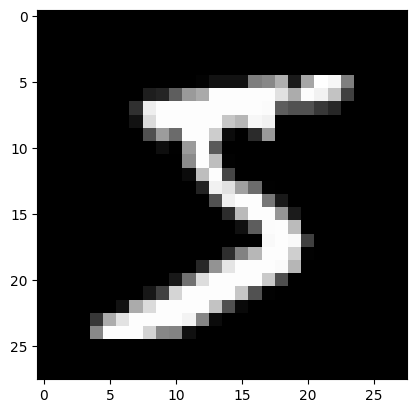

In [ ]:
idx = 0
img = mnist_tr.data[idx].cpu()  # NB: to plot the data, we need to move it back from the GPU memory!
print("The image shows the digit: {}".format(mnist_tr.targets[idx]) )
plt.imshow(img , cmap = 'gray')
plt.show()

## Training a Deep Belief Network
Quick recall from the course theory:
- DBNs are hierarchical generative models made by a stack of Restricted Boltzmann Machines, which are a family of *undirected* graphical models;
- learning is *unsupervised*, since the goal is to learn the probability distribution that could have generated the training data (maximum-likelihood);
- DBNs can process the input data through a *forward* (bottom-up) pass to compute hidden representations of the sensory input ("inference" over latent variables);
- DBNs can also generate plausible sensory input through a *backward* (top-down) pass, which can be used to produce class prototypes;
- DBNs are trained using an algorithm called *contrastive divergence*, whose goal is to reduce the difference between the learned probability distribution and the true (empirical) one.

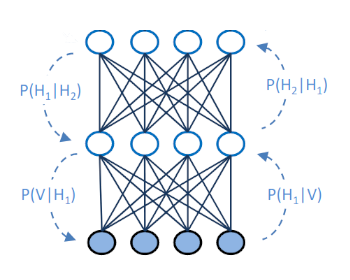

In [ ]:
dbn_mnist = DBN(visible_units=28*28,          # dimensionality of the sensory data
                hidden_units=[400, 500, 800], # size of hidden layers
                k=1,                          # reconstruction steps in Contrastive Divergence
                learning_rate=0.01,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

Iterative DBN initialized:
  Architecture: [784, 400, 500, 800]
  Layers: 3
  CD-k: 1
  Device: cuda


Let's train the model:

In [ ]:
num_epochs = 100
batch_size = 125

dbn_mnist.train_static(
    mnist_tr.data,
    mnist_tr.targets,
    num_epochs,
    batch_size
)


Starting ITERATIVE training
Epochs: 100, Batch size: 125

Epoch   0/100: L1: 0.0451, L2: 0.0247, L3: 0.0119
Momentum updated to 0.95
Epoch  10/100: L1: 0.0109, L2: 0.0133, L3: 0.0073
Epoch  20/100: L1: 0.0096, L2: 0.0115, L3: 0.0065
Epoch  30/100: L1: 0.0092, L2: 0.0108, L3: 0.0063
Epoch  40/100: L1: 0.0090, L2: 0.0105, L3: 0.0061
Epoch  50/100: L1: 0.0089, L2: 0.0103, L3: 0.0060
Epoch  60/100: L1: 0.0088, L2: 0.0101, L3: 0.0060
Epoch  70/100: L1: 0.0087, L2: 0.0100, L3: 0.0059
Epoch  80/100: L1: 0.0087, L2: 0.0099, L3: 0.0059
Epoch  90/100: L1: 0.0087, L2: 0.0098, L3: 0.0059
Epoch  99/100: L1: 0.0086, L2: 0.0098, L3: 0.0058

Iterative training complete!



## Visualizing receptive fields

After training, we can visualize the "receptive fields" of each hidden neuron by plotting the corresponding learned weights. This allows to analyze which parts and which features of an image trigger the unit associated with a specific weight vector.

It might also be useful to apply a threshold on the learned weights, in order to make the plots less noisy. Finally, the values in different weigths could have different ranges, so we will use a `MinMaxScaler` from Scikit-Learn to make a meaningful comparison among the visualizations of different receptive fields.

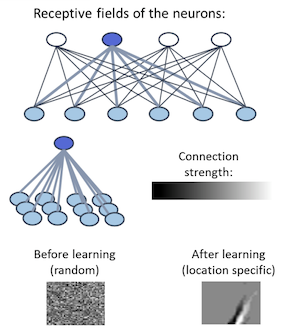

In [ ]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().detach().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

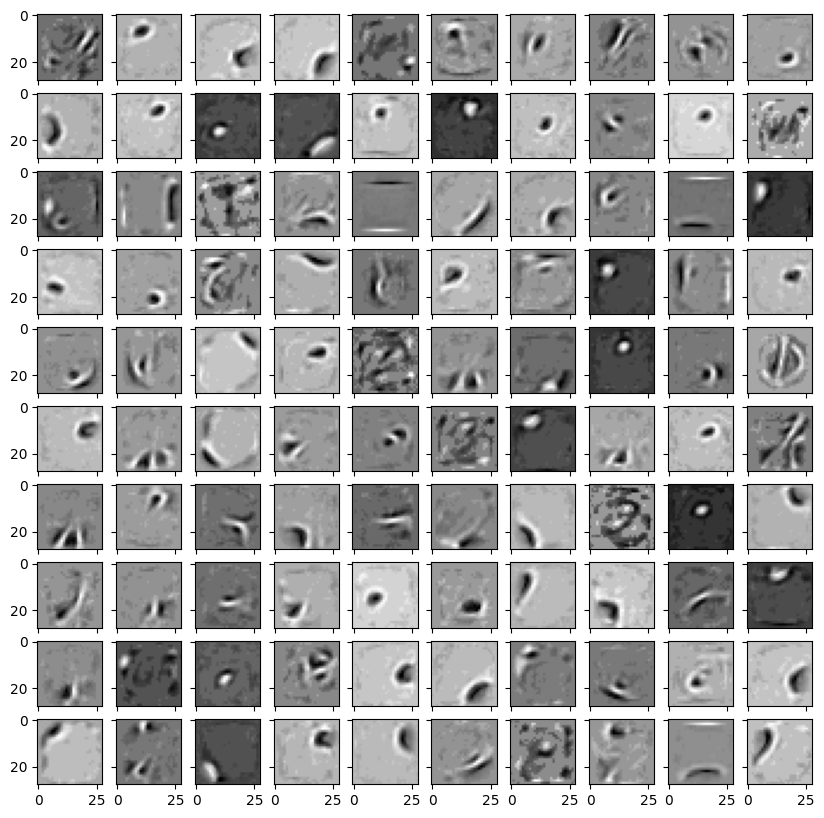

In [ ]:
w1 = get_weights(dbn_mnist, layer=0)
w1 = apply_threshold(w1, 0.1)
w1 = apply_min_max_scaler(w1)

plot_layer_receptive_fields(w1.T)

The weights in the second and third hidden layers have don't have the same dimensionality as MNIST digits, therefore, we will need to project each of the vectors in a space of dimensionality `784` (`28`x`28`) in order to visualize them as images. The projection can be done in many ways, here for simplicity we consider a [linear projection](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html).

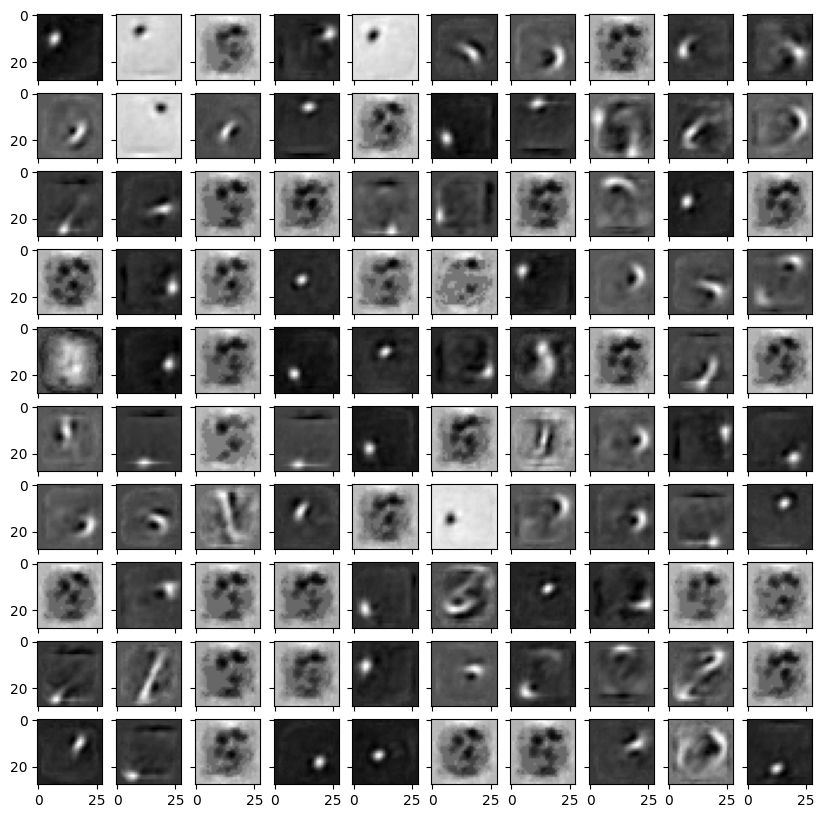

In [ ]:
w1 = get_weights(dbn_mnist, layer=0)
w2 = get_weights(dbn_mnist, layer=1)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)

w_product = (w1 @ w2)  # here we do the projection
w_product = apply_threshold(w_product, 0.1)
w_product = apply_min_max_scaler(w_product)

plot_layer_receptive_fields(w_product.T)

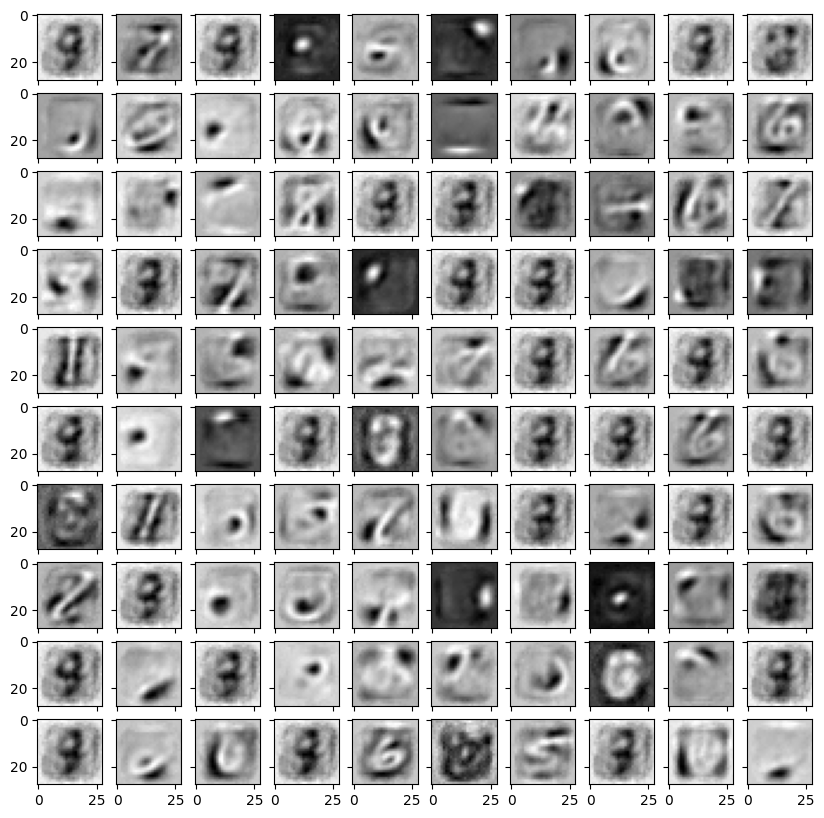

In [ ]:
w1 = get_weights(dbn_mnist, layer=0)
w2 = get_weights(dbn_mnist, layer=1)
w3 = get_weights(dbn_mnist, layer=2)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)
w3 = apply_threshold(w3, 0.1)

w_product_12 = (w1 @ w2)  # here we do the projection
w_product_23 = (w_product_12 @ w3)  # here we do the projection
w_product_23 = apply_threshold(w_product_23, 0.1)
w_product_23 = apply_min_max_scaler(w_product_23)

plot_layer_receptive_fields(w_product_23.T)

## Clustering internal representations

We can also examine the properties of the learned *distributed* representations. For example, we can compute the centroid of the representations learned for each class, and see how close they are to each other using a standard hierarchical clustering algorithm.

This implementation of the `DBN` contains internally several `RBM` objects. Therefore, we will need to compute the hidden representation using the weights of each `RBM`.

In [ ]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_mnist.rbm_layers[k].to_hidden(flattened_input) # here we access the RBM object
  return hidden_repr.detach()

The representations computed for the second hidden layer are derived using the ones of the first hidden layer, and so on until we get to the deepest layer:

In [ ]:
hidden_repr_1 = get_kth_layer_repr(mnist_tr.data, 0, device)
hidden_repr_2 = get_kth_layer_repr(hidden_repr_1, 1, device)
hidden_repr_3 = get_kth_layer_repr(hidden_repr_2, 2, device)
print(hidden_repr_1.shape)
print(hidden_repr_2.shape)
print(hidden_repr_3.shape)

torch.Size([60000, 400])
torch.Size([60000, 500])
torch.Size([60000, 800])


In [ ]:
def plot_pca_2d(representations, labels, title="PCA 2D Visualization"):
  """
   Plot 2D PCA visualization of representations colored by labels.
   Args:    representations: torch.Tensor or np.ndarray (N, D)
   labels: torch.Tensor or np.ndarray (N,)
   title: str, plot title
   """
  from sklearn.decomposition import PCA
  if isinstance(representations, torch.Tensor):
    representations = representations.cpu().detach().numpy()
  if isinstance(labels, torch.Tensor):
    labels = labels.cpu().numpy()
  # Apply PCA
  pca = PCA(n_components=2)
  coords_2d = pca.fit_transform(representations)
  # Plot
  fig, ax = plt.subplots(figsize=(10, 8))
  scatter = ax.scatter(coords_2d[:, 0], coords_2d[:, 1], c=labels, cmap='tab10', alpha=0.6, s=20)
  ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
  ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
  ax.set_title(title)
  plt.colorbar(scatter, label='Digit Label')
  plt.grid(alpha=0.3)
  plt.tight_layout()


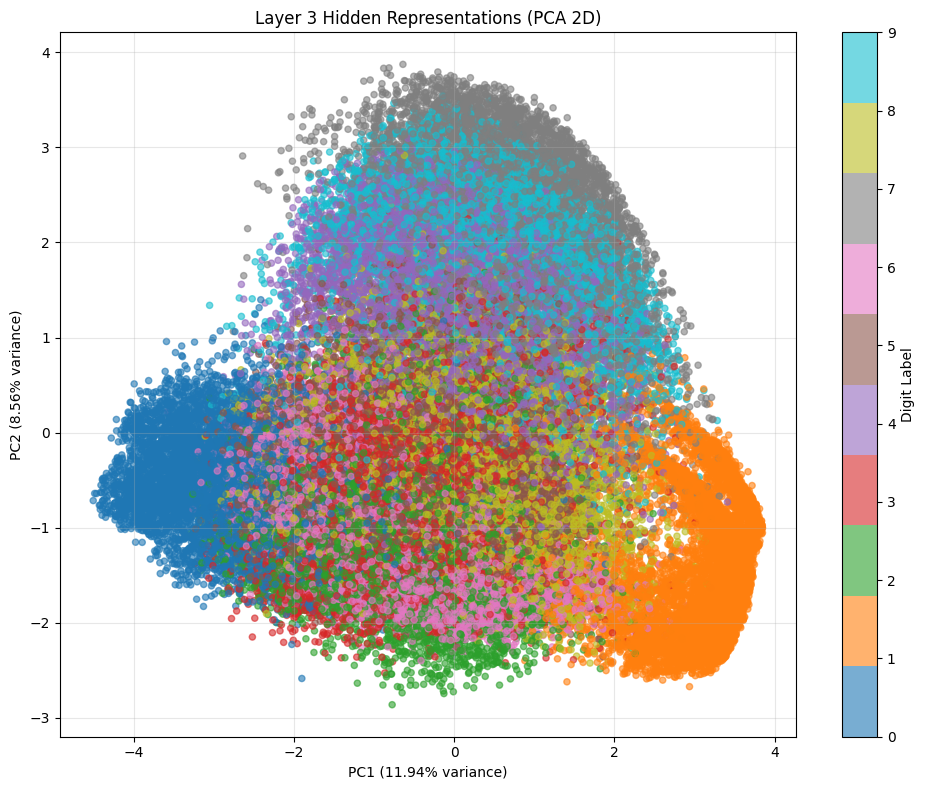

In [ ]:
plot_pca_2d(hidden_repr_3, mnist_tr.targets, title="Layer 3 Hidden Representations (PCA 2D)")


## Linear read-out

Another technique to analyze distributed representaitons is to decode them using a linear readout (as for the clustering, this can be done at each layer of the DBN). We will thus use the hidden representations to classify the MNIST images with a simple linear classifier, as a way to assess how much information is contained in each hidden representatation.
Let's first define the class for the linear classifier:

In [ ]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)

  def forward(self, x):
    return self.linear(x)

Then, we can instantiate a linear classifier for each hidden layer of the DBN:

In [ ]:
layer_size = dbn_mnist.rbm_layers[0].W.detach().shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_mnist.rbm_layers[1].W.detach().shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_mnist.rbm_layers[2].W.detach().shape[1]
linear3 = LinearModel(layer_size).to(device)

Then, we train the linear classifiers on the hidden representations from each layer using the actual labels of the MNIST dataset as targets:

In [ ]:
def train_linear(linear, hidden_reprs):
  optimizer = torch.optim.SGD(linear.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  epochs = 1000

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = linear(hidden_reprs).squeeze()
    targets = mnist_tr.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [ ]:
train_linear(linear1, hidden_repr_1)

epoch :   1/1000, loss = 2.3432
epoch : 101/1000, loss = 0.7658
epoch : 201/1000, loss = 0.5452
epoch : 301/1000, loss = 0.4567
epoch : 401/1000, loss = 0.4069
epoch : 501/1000, loss = 0.3741
epoch : 601/1000, loss = 0.3504
epoch : 701/1000, loss = 0.3322
epoch : 801/1000, loss = 0.3176
epoch : 901/1000, loss = 0.3056


In [ ]:
train_linear(linear2, hidden_repr_2)

epoch :   1/1000, loss = 2.3414
epoch : 101/1000, loss = 0.8518
epoch : 201/1000, loss = 0.5957
epoch : 301/1000, loss = 0.4918
epoch : 401/1000, loss = 0.4336
epoch : 501/1000, loss = 0.3956
epoch : 601/1000, loss = 0.3684
epoch : 701/1000, loss = 0.3476
epoch : 801/1000, loss = 0.3311
epoch : 901/1000, loss = 0.3176


In [ ]:
train_linear(linear3, hidden_repr_3)

epoch :   1/1000, loss = 2.3114
epoch : 101/1000, loss = 0.8544
epoch : 201/1000, loss = 0.5775
epoch : 301/1000, loss = 0.4658
epoch : 401/1000, loss = 0.4041
epoch : 501/1000, loss = 0.3643
epoch : 601/1000, loss = 0.3361
epoch : 701/1000, loss = 0.3148
epoch : 801/1000, loss = 0.2981
epoch : 901/1000, loss = 0.2846


Let's now evaluate the trained linear readouts using the hidden representations computed on the *test* set:

In [ ]:
hidden_repr_1_test = get_kth_layer_repr(mnist_te.data, 0, device)
hidden_repr_2_test = get_kth_layer_repr(hidden_repr_1_test, 1, device)
hidden_repr_3_test = get_kth_layer_repr(hidden_repr_2_test, 2, device)

In [ ]:
# compute the classifier predictions:
predictions_test1 = linear1(hidden_repr_1_test)
predictions_test2 = linear2(hidden_repr_2_test)
predictions_test3 = linear3(hidden_repr_3_test)

Finally, let's compute the accuracy scores:

In [ ]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [ ]:
compute_accuracy(predictions_test1, mnist_te.targets)

0.9300999641418457

In [ ]:
compute_accuracy(predictions_test2, mnist_te.targets)

0.9309999942779541

In [ ]:
compute_accuracy(predictions_test3, mnist_te.targets)

0.9407999515533447

## Robustness to noise

We will now inject some noise in the input images and see how much the representations learned by the DBN and the feed-forward network are robust to perturbations in the sensory signal.

Similarly to what happens in psychophysical experiments, this will allow to create a psychometric curve describing the decrease in classification accuracy with respect to the noise level.

In [ ]:
def inject_noise(mnist_data, noise_level):

  random_gaussian_tensor = torch.randn(mnist_data.shape, device = device)*noise_level
  return mnist_data + random_gaussian_tensor


Let's see what a noisy image looks like:


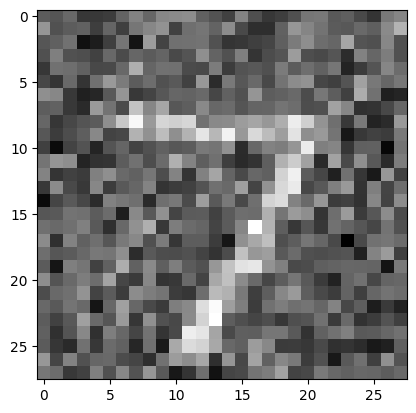

In [ ]:
noise_level = 0.3
mnist_test_with_noise = inject_noise(mnist_te.data, noise_level)
__ = plt.imshow(mnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")

We will now compute the hidden representations for the noisy images using the DBN. Then, we will use the read-out classifiers that we trained on the representations without noise to classify the noisy stimuli.

In [ ]:
def get_accuracy_values_at_noise_level(noise_level):

  mnist_test_with_noise = inject_noise(mnist_te.data, noise_level)  # first, let's create noisy test images

  hidden_repr_1_noisy = get_kth_layer_repr(mnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_2_noisy = get_kth_layer_repr(hidden_repr_1_noisy, 1, device)
  hidden_repr_3_noisy = get_kth_layer_repr(hidden_repr_2_noisy, 2, device)

  predictions_first_hidden_noisy = linear1(hidden_repr_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_3_noisy)

  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, mnist_te.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, mnist_te.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, mnist_te.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden

In [ ]:
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])


Accuracy of H1 read-out: 0.906
Accuracy of H2 read-out: 0.922
Accuracy of H3 read-out: 0.935


Let's create the psychometric curves for the DBN (at different levels of internal representations):

In [ ]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

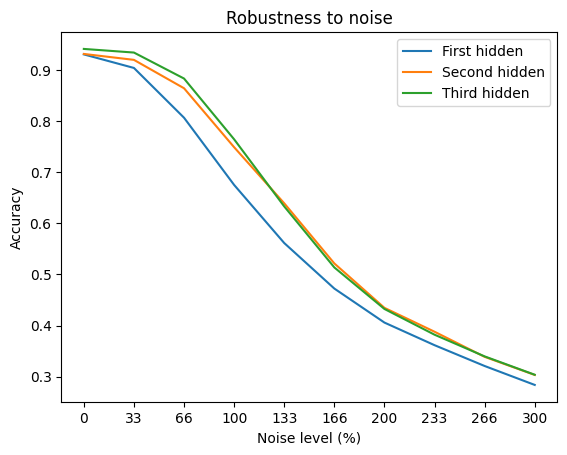

In [ ]:
noise_levels = np.linspace(0,3,10)
plot_noise_robustness_curves(noise_levels)

## Reference papers
- [G. Hinton - A Practical Guide to Training Restricted Boltzmann Machines](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf)
- [G. Hinton, R. Salakhutdinov - Reducing the Dimensionality of Data with Neural Networks](https://www.science.org/doi/10.1126/science.1127647)
- [Testolin et al. - Deep unsupervised learning on a desktop PC: a primer for cognitive scientists](https://www.frontiersin.org/articles/10.3389/fpsyg.2013.00251/full)


## Load StoianovZorzi2012 Dataset

This dataset contains images of objects from different viewpoints, used for studying invariant representations in DBNs.

In [ ]:
import scipy.io as sio
import matplotlib.pyplot as plt

# Load the .mat file
mat_data = sio.loadmat('StoianovZorzi2012_data.mat')

# Extract images and labels
stoianov_images = mat_data['data_images']  # Shape: (51200, 900) - 30x30 images
stoianov_labels = mat_data['data_labels']  # Shape: (51200, 2) - [object_id, viewpoint]

print(f"Dataset loaded:")
print(f"  Number of images: {stoianov_images.shape[0]}")
print(f"  Image size: 30x30 pixels ({stoianov_images.shape[1]} features)")
print(f"  Number of objects: {len(np.unique(stoianov_labels[:, 0]))}")
print(f"  Number of viewpoints: {len(np.unique(stoianov_labels[:, 1]))}")
print(f"  Value range: [{stoianov_images.min():.2f}, {stoianov_images.max():.2f}]")

# Visualize some examples
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
fig.suptitle('StoianovZorzi2012 Dataset - Sample Images', fontsize=14)

for i, ax in enumerate(axes.flat):
    img = stoianov_images[i * 1600].reshape(30, 30)  # Sample every 1600th image
    obj_id = int(stoianov_labels[i * 1600, 0])
    viewpoint = int(stoianov_labels[i * 1600, 1])
    
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Obj {obj_id}\n{viewpoint}°', fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\nDataset structure:")
print(f"  Object IDs: {np.unique(stoianov_labels[:, 0]).astype(int)}")
print(f"  Viewpoints: {np.unique(stoianov_labels[:, 1]).astype(int)} degrees")

### Convert to PyTorch tensors for DBN training

In [ ]:
import torch

# Convert to PyTorch tensors
stoianov_data = torch.from_numpy(stoianov_images).float()
stoianov_object_labels = torch.from_numpy(stoianov_labels[:, 0]).long() - 1  # Object IDs (0-31)
stoianov_viewpoint_labels = torch.from_numpy(stoianov_labels[:, 1]).long()   # Viewpoints

# Split into train and test sets (80-20 split)
n_samples = stoianov_data.shape[0]
n_train = int(0.8 * n_samples)

indices = torch.randperm(n_samples)
train_indices = indices[:n_train]
test_indices = indices[n_train:]

stoianov_train_data = stoianov_data[train_indices]
stoianov_train_obj_labels = stoianov_object_labels[train_indices]
stoianov_train_view_labels = stoianov_viewpoint_labels[train_indices]

stoianov_test_data = stoianov_data[test_indices]
stoianov_test_obj_labels = stoianov_object_labels[test_indices]
stoianov_test_view_labels = stoianov_viewpoint_labels[test_indices]

print(f"Data prepared for DBN training:")
print(f"  Training set: {stoianov_train_data.shape[0]} samples")
print(f"  Test set: {stoianov_test_data.shape[0]} samples")
print(f"  Input dimension: {stoianov_train_data.shape[1]} (30x30 pixels)")
print(f"\nReady to train DBN with:")
print(f"  dbn_stoianov = DBN(visible_units=900, hidden_units=[500, 500, 2000], ...)")
print(f"  dbn_stoianov.train_static(stoianov_train_data, stoianov_train_obj_labels, num_epochs=50, batch_size=128)")